In [2]:
import sys
sys.path.insert(0,"../../")

from library import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Bet

In [312]:
class Bet:
    def __init__(self,desc=None,bet=True,amount=0,odds=0.5,prior=1):
        self.desc = desc
        self.amount = -abs(amount)
        self.prior = prior
        self.odds = odds
        self.odds_a = 1/(1-1/self.odds)

        self.p = 1/self.odds
        self.p_a = 1-self.p

        self.pot_ret = amount * self.odds
        self.pot_ret_a = amount * self.odds_a
        self.x_ret = self.pot_ret * self.p + self.amount*(1-self.p)
        self.x_rev = self.x_ret + self.amount
        self.x_ret_a = self.pot_ret_a * self.p_a + self.amount*(1-self.p_a)
        self.x_rev_a = self.x_ret_a + self.amount
        self.bet = bet
        self.success = 0
        self.returns = 0
        self.revenue = 0


    def materialize(self,desc,outcome):
        if desc == self.desc:
            self.success = {True:1,False:-1}[outcome == self.bet]
            self.returns = abs(self.amount) * self.odds if outcome == self.bet else 0
            self.revenue = self.returns + self.amount
        return self

    def as_frame(self):
        return pd.DataFrame([{
            'desc'      : self.desc,
            'bet'       : self.bet,
            'amount'    : np.round(self.amount,2),
            'prior'     : np.round(self.prior,2),
            'odds'      : np.round(self.odds,2),
            'odds_a'    : np.round(self.odds_a,2),
            'p'         : np.round(self.p,2),
            'p_a'       : np.round(self.p_a,2),
            'pot_ret'   : np.round(self.pot_ret,2),
            'pot_ret_a' : np.round(self.pot_ret_a,2),
            'x_ret'     : np.round(self.x_ret,2),
            'x_ret_a'   : np.round(self.x_ret_a,2),
            'x_rev'     : np.round(self.x_rev,2),
            'x_rev_a'   : np.round(self.x_rev_a,2),
            'success'   : np.round(self.success,2),
            'returns'   : np.round(self.returns,2),
            'revenue'   : np.round(self.revenue,2),  
        }])


class BetSlip:
    def __init__(self):
        self.bets = []

    def add_bet(self,*bets):
        self.bets += bets

    def add_outcome(self,desc,outcome):
        for bet in self.bets:
            bet.materialize(desc,outcome)

    def as_frame(self):
        bet_frame = pd.concat([b.as_frame() for b in self.bets],axis=0,ignore_index=True)
        cols_sum = ['amount','pot_ret','x_ret','x_rev','pot_ret_a','x_ret_a','x_rev_a','success','returns','revenue']
        cols_avg = ['odds','odds_a']
        bet_frame.loc["Total",cols_sum] = np.round(bet_frame[cols_sum].sum(),2)
        bet_frame.loc["Total",cols_avg] = np.round(bet_frame[cols_avg].mean(),2)
        bet_frame.loc["Total",bet_frame.columns.drop([*cols_sum,*cols_avg])] = ''
        return bet_frame

    def total_returns(self):
        return self.as_frame()['returns'].sum()

    def total_bets(self):
        return self.as_frame()['amount'].sum()

    def net_revenue(self):
        return self.total_returns() - self.total_bets()


In [313]:
b = Bet("Chicago wins/ties 1st half",True,5,4.0,prior=0.6)
b2 = Bet("Milwaukee wins/ties 1st half",True,10,2.0,prior=0.6)
b3 = Bet("Giannis scores 30pts",False,10,1.25,prior=0.6)
b3.as_frame()

,desc,bet,amount,prior,odds,odds_a,p,p_a,pot_ret,pot_ret_a,x_ret,x_ret_a,x_rev,x_rev_a,success,returns,revenue
0,Giannis scores 30pts,False,-10,0.6,1.25,5.0,0.8,0.2,12.5,50.0,8.0,2.0,-2.0,-8.0,0,0,0


In [303]:
s = BetSlip()
s.add_bet(b,b2,b3)
s.as_frame()

,desc,bet,amount,odds,odds_a,p,p_a,pot_ret,pot_ret_a,x_ret,x_ret_a,x_rev,x_rev_a,success,returns,revenue
0,Chicago wins/ties 1st half,True,-5.0,4.00,1.33,0.25,0.75,20.0,6.67,1.25,3.75,-3.75,-1.25,0.0,0.0,0.0
1,Milwaukee wins/ties 1st half,True,-10.0,2.00,2.00,0.5,0.5,20.0,20.00,5.00,5.00,-5.00,-5.00,0.0,0.0,0.0
2,Giannis scores 30pts,False,-10.0,1.25,5.00,0.8,0.2,12.5,50.00,8.00,2.00,-2.00,-8.00,0.0,0.0,0.0
Total,,,-25.0,2.42,2.78,,,52.5,76.67,14.25,10.75,-10.75,-14.25,0.0,0.0,0.0


In [249]:
s.add_outcome("Chicago wins/ties 1st half",False)
s.add_outcome("Milwaukee wins/ties 1st half",True)
s.as_frame()

,desc,bet,amount,odds,pot_ret,p_bet,x_ret,x_rev,success,returns,revenue
0,Chicago wins/ties 1st half,True,-5.0,4.00,20.0,0.25,1.25,-3.75,-1.0,0.0,-5.0
1,Milwaukee wins/ties 1st half,True,-10.0,2.00,20.0,0.50,5.00,-5.00,1.0,20.0,10.0
2,Giannis scores 30pts,False,-10.0,1.25,12.5,0.80,8.00,-2.00,0.0,0.0,0.0
Total,,,-25.0,2.42,52.5,0.52,14.25,-10.75,0.0,20.0,5.0


In [276]:
[x/(x+e) for x in range(1,10)]

[0.2689414213699951,
 0.42388311523417094,
 0.5246331135813284,
 0.5953903248083103,
 0.6478125716482486,
 0.6882089978342096,
 0.7202919326234376,
 0.7463882857379718,
 0.768030683315926]

Text(0, 0.5, 'rev')

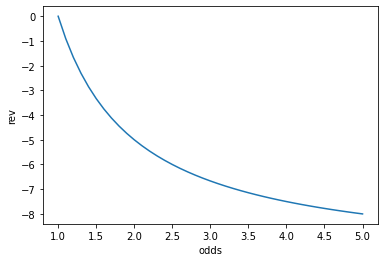

In [252]:
odds = np.linspace(1,5,41)
amt = 10
w_probs = 1/odds
l_probs = 1 - w_probs
x_ret = (amt*odds*w_probs + -amt*l_probs) - amt

plt.plot(odds,x_ret)
plt.xlabel("odds")
plt.ylabel("rev")

In [280]:
1.2, 5.5

1/5.5

0.18181818181818182

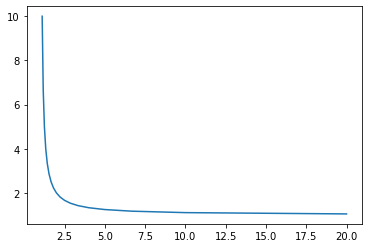

In [283]:
[(1/x,1/(1-x)) for x in np.arange(0.05,0.95,0.05)]
plt.plot(
    [1/x for x in np.arange(0.05,0.95,0.05)],
    [1/(1-x) for x in np.arange(0.05,0.95,0.05)],
)

In [288]:
1/1.8 + 1/2.2

1.0101010101010102